# Common imports

In [1]:
%matplotlib notebook
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import time
import random

# Provided functions
### Image loading and saving

In [2]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [3]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [4]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    ax.yaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [5]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [6]:
def preprocess(ambimage, imarray):
    """
    preprocess the data: 
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    ambimage_array=np.stack([np.array(ambimage) for _ in range(imarray.shape[-1])], axis=-1) 
    subtracted=imarray-ambimage_array
    subtracted[subtracted<0]=0
    processed_imarray=subtracted/255.0

    return processed_imarray

In [7]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h, w, Nimages=imarray.shape
    npix=h*w
    g = np.zeros((h, w, 3))
    imarray=imarray.reshape(npix,Nimages).transpose()
    g = np.linalg.lstsq(light_dirs, imarray)[0]
    albedo_image=np.linalg.norm(g,axis=0)
    surface_normals=g/albedo_image
    albedo_image=albedo_image.reshape(h,w)
    surface_normals=surface_normals.transpose().reshape(h,w,3)
    
    return albedo_image, surface_normals

In [8]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """
    fx=surface_normals[:,:,0]/surface_normals[:,:,2]
    fy=surface_normals[:,:,1]/surface_normals[:,:,2]
    cum_x=np.cumsum(fx,axis=1)
    cum_y=np.cumsum(fy,axis=0)
    print(cum_x)
    h=surface_normals.shape[0]
    w=surface_normals.shape[1]
    height_map = np.zeros((h,w))
    
    def row():
        return cum_y + cum_x[0,:][np.newaxis,:]
    def column():
        return cum_x + cum_y[:,0][:,np.newaxis]
    def average():
        return (cum_y + cum_x[0,:][np.newaxis,:]+cum_x + cum_y[:,0][:, np.newaxis])/2
    def random():
        #run 50 times and take the average
        random_sum=np.zeros((h,w))
        for i in range(50):
            random_height_map = np.zeros((h, w))
            random_height_map[0,:] = cum_x[0,:]
            random_height_map[:,0] = cum_y[:,0]
            for j in range(1,h):
                for k in range(1,w):
                    random_height_map[j,k] = [random_height_map[j,k-1] + fx[j,k], random_height_map[j-1,k]+fy[j,k]][np.random.randint(0,1)]
            random_sum+=random_height_map
        return random_sum/50
        
    method = {'row': row, 'column': column, 'average': average, 'random': random}

    start = time.time()
    height_map = method[integration_method]()
    elapsed = time.time() - start
    print('Method:',integration_method)
    print('Runing time:', elapsed)

    return height_map

# Main function

In [9]:
root_path = './croppedyale/'
subject_name = 'yaleB02'
integration_method = 'row'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)

ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)

albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                   light_dirs)
height_map = get_surface(surface_normals, integration_method)
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)

/Users/garethfeng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


[[ 1.08992486  2.19611568  3.28858554 ... 18.20255615 17.35914359
  16.52822437]
 [ 1.14094495  2.28674685  3.57115805 ... 18.7474144  17.87964293
  17.03056486]
 [ 1.17198961  2.3292758   3.64193036 ... 19.46559361 18.58330926
  17.71959321]
 ...
 [ 1.02665337  1.97364273  3.03397349 ...  8.88407759  8.0521875
   7.1660032 ]
 [ 1.23136879  2.20863455  3.29640212 ...  8.96960196  8.12120519
   7.32998173]
 [ 1.06143441  2.06462353  3.18939024 ...  9.86292412  9.00075617
   8.1919985 ]]
Method: row
Runing time: 0.00025391578674316406


<IPython.core.display.Javascript object>


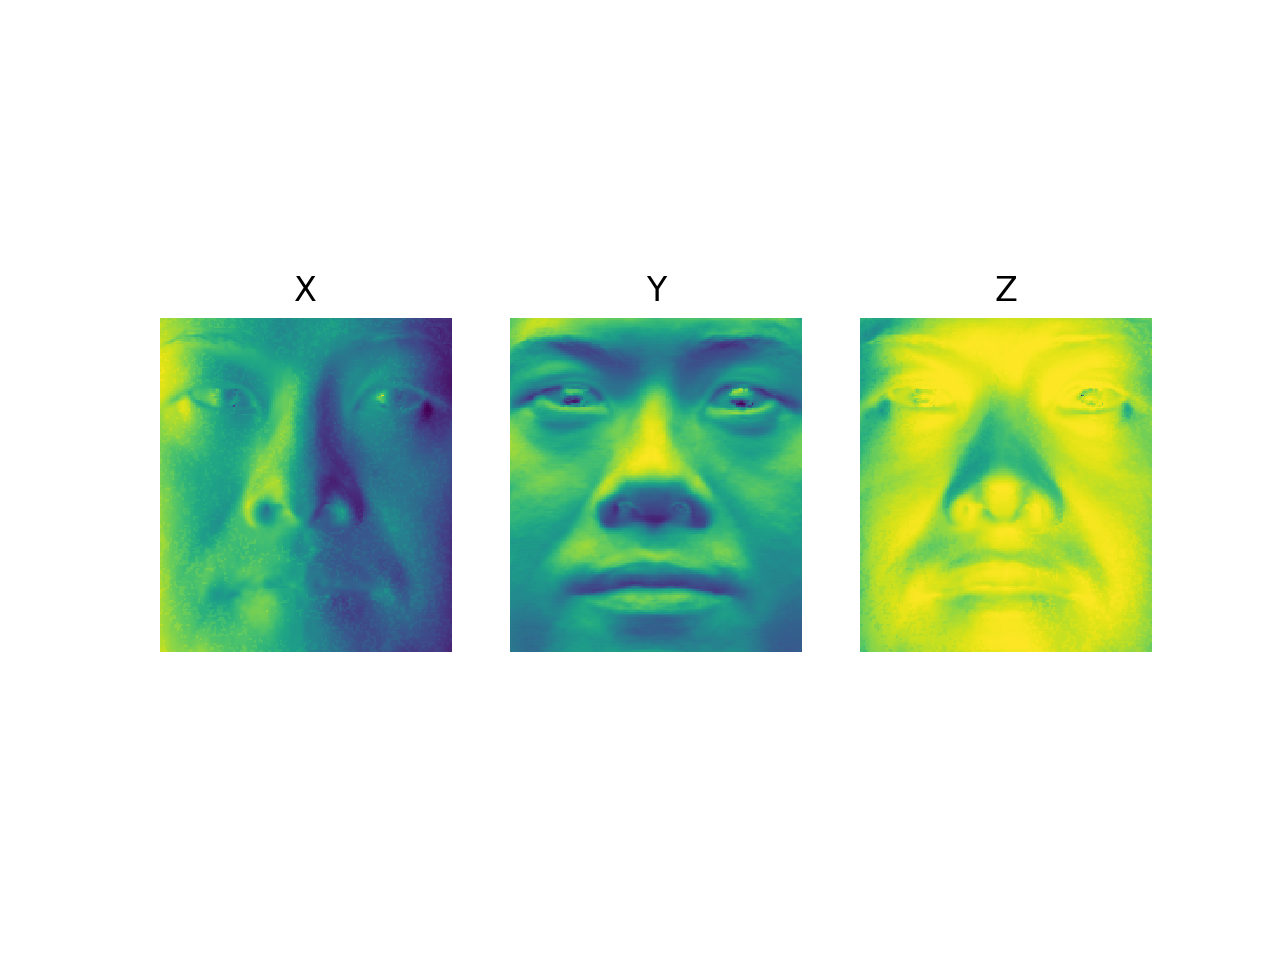

In [10]:
plot_surface_normals(surface_normals)

<IPython.core.display.Javascript object>


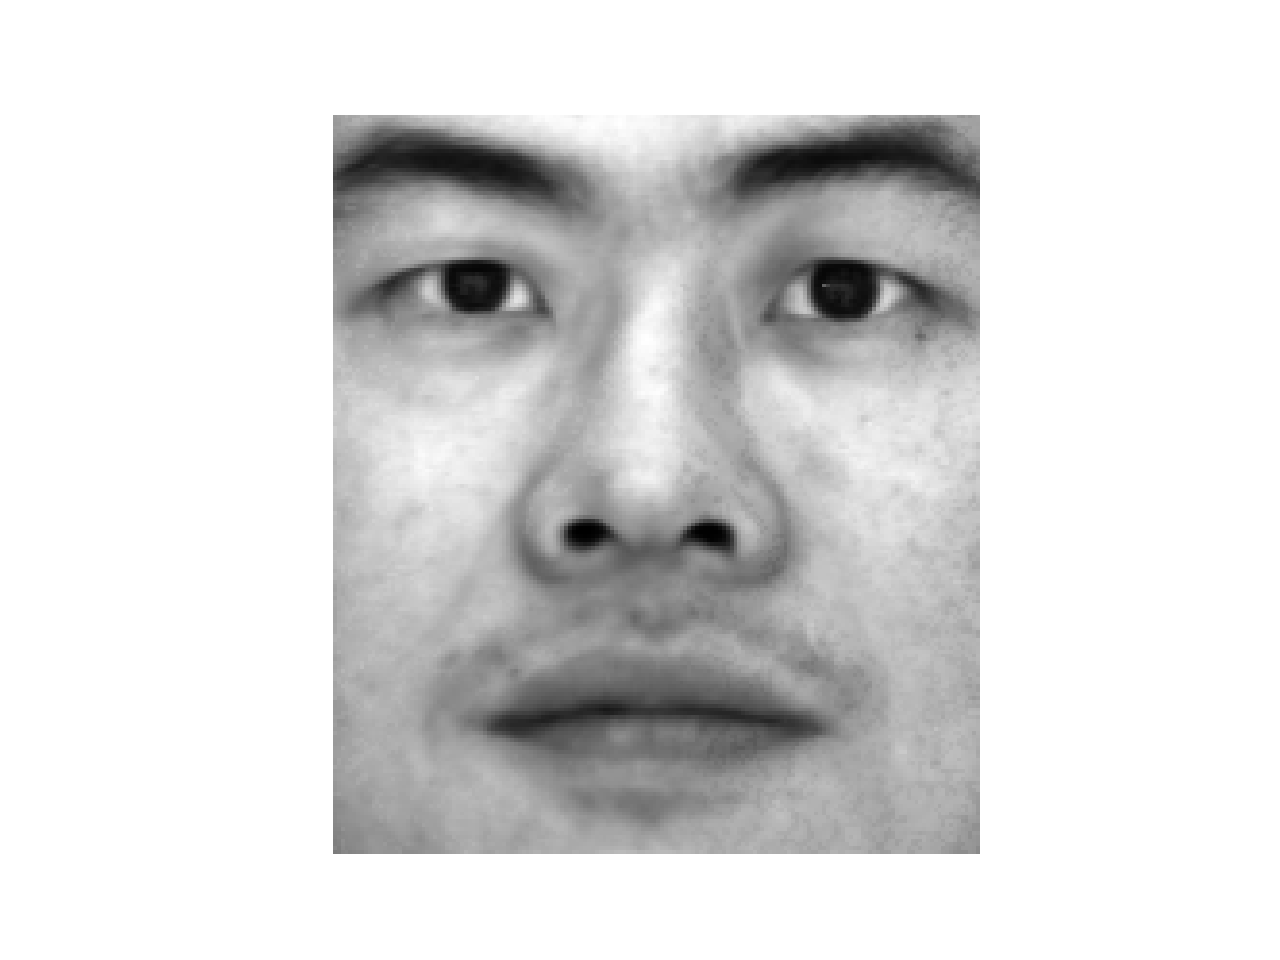

<IPython.core.display.Javascript object>


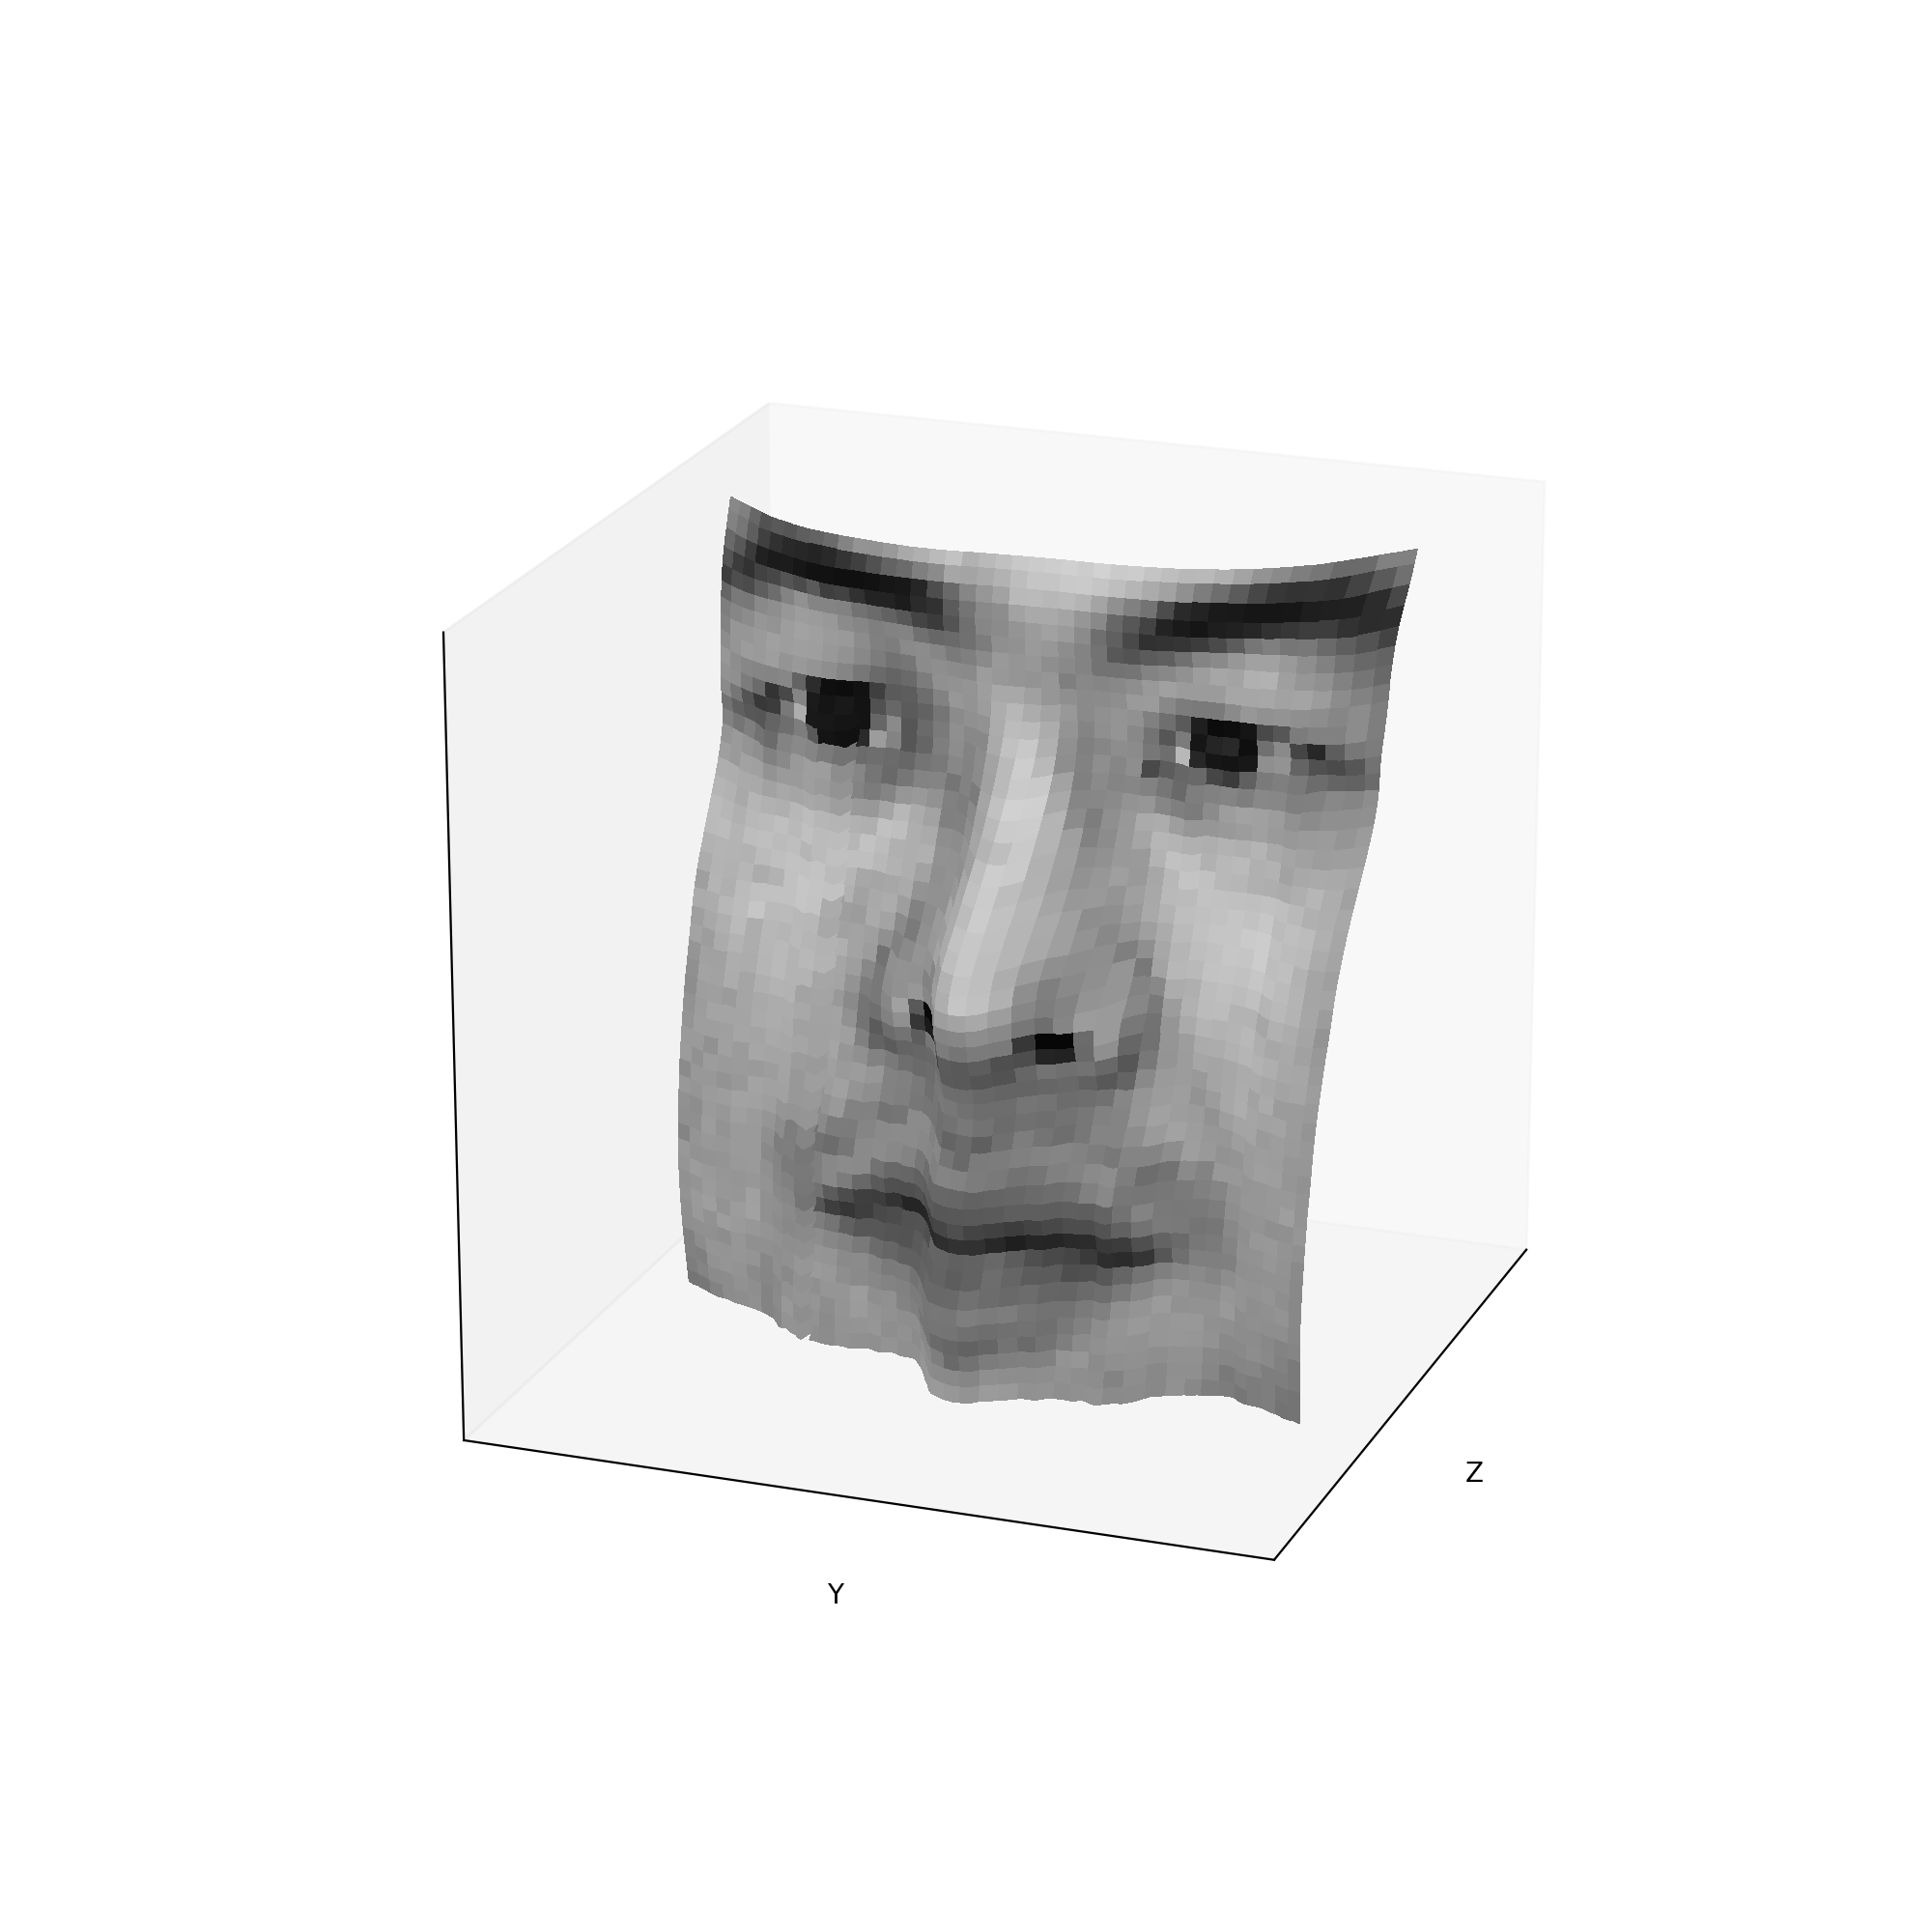

In [11]:
display_output(albedo_image, height_map)